<a href="https://colab.research.google.com/github/HBocaccio/NumLabIMC/blob/main/Colabs/nb08_Reconstrucci%C3%B3nODEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> (Última Actualización: 8 de Octubre de 2025)

# **Introducción al modelado continuo** (*a.k.a.* **Ecuaciones de la física matemática**)
## Laboratorio numérico

Bienvenidos al laboratorio numérico de la materia *Introducción al modelado continuo*, también conocida como *Ecuaciones de la física matemática*. En este, vamos a ver métodos numéricos para resolver distintos tipos de problemas de manera general, y su relación y aplicación a problemas específicos de la materia, de manera tal de complementar los contenidos de la cursada teórico-práctica.

# Motivación de este colab
<!-- $$\require{amsmath}$$ -->

Recordemos que estamos estudiando **sistemas dinámicos**, con reglas representadas por **ecuaciones diferenciales ordinarias (ODEs)**. Hasta ahora, vimos como partiendo de los modelos definidos por estas ecuaciones podemos estudiar un cierto sistema dinámico analizando las características matemáticas que surgen de las ecuaciones que lo describen (o al menos describen ciertas propiedades del fenómeno). Esto incluía la integración de las ecuaciones para encontrar la evolución temporal de las variables. Pero qué pasaría si en lugar de tener el modelo que describe un fenómeno, tenemos sólo la evolución temporal de las variables?

En esta clase vamos a ver cómo podemos pensar estrategias para **reconstruir las ecuaciones** que rigen a un sistema dinámico a partir de conocer los valores de las variables para distintos tiempos. Se trata por lo tanto de una estrategia de modelado data-driven, porque vamos a construir un modelo de un sistema dinámico a partir de datos.

# Reconstrucción de ODEs

En este Colab vamos a ver una estrategia de modelado data-driven para encontrar las ecuaciones diferenciales de un sistema a partir de la serie temporal de sus variables. Este Colab es una adaptación de una de las guías de la materia *Sistemas dinamicos e inteligencia artificial aplicado al modelado de datos*:
https://materias.df.uba.ar/sdeiaaamdda2021c2/guias/

El método de reconstrucción de ODEs a partir de los datos fue propuesto en el siguiente paper:
https://www.pnas.org/doi/abs/10.1073/pnas.1517384113

Se basa en plantear que las ODEs plantean una relación lineal entre las derivadas de las variables (variables dependientes) y transformaciones de las variables en una base de funciones (variables independientes), como por ejemplo, tener todos los posibles términos polinómicos que combinan variables mediante la multiplicación, hasta un cierto orden. De esta manera, se puede plantear una regresión lineal y estimar los coeficientes que multiplican a las variables transformadas. Si además aplicamos una penalización de tipo LASSO, lo que hace que muchos coeficientes se hagan cero, vamos a obtener una matriz de coeficientes esparsa, y la mayoría de los términos posibles no van a aparecer. Entonces, vamos a obtener un conjunto chico de términos que describen el campo vector, pudiendo reconstruir las ODEs que describen la dinámica del sistema.

La única suposición sobre la estructura del modelo es que sólo hay unos pocos términos importantes que gobiernan la dinámica del sistema, de modo que las ecuaciones son esparsas (sobreviven pocos términos debido a que la mayoría de los coeficientes son cero) en el espacio de funciones posibles. Esta suposición se cumple para muchos sistemas físicos en una base apropiada.

En el paper de referencia aplican este método a datos simulados del atractor de Lorenz, computan los valores al transformar las variables a una base polinómica, y estiman la matriz de coeficientes de donde reconstruyen las ecuaciones que describen el sistema original. Esto se describe en la siguiente figura:
![](https://dt5vp8kor0orz.cloudfront.net/5d150cec2775f9bc863760448f14104cc8f42368/5-Figure1-1.png)


# Reconstrucción del atractor de Lorenz

En esta primera parte, vamos a trabajar en reconstruir las ecuaciones de Lorenz a partir de datos. Para ello, primero vamos a generar un conjunto de datos a partir de integrar el sistema de Lorenz. De esta manera, tendremos una simulación de la evolución temporal de las variables de un atractor de Lorenz. Vamos a considerar que estos son nuestros datos reales, y vamos a usar estos datos para hacer el proceso inverso e inferir las ecuaciones diferenciales que rigen el sistema.

## Generación de datos simulados

Definimos el sistema de Lorenz y simulamos datos como soluciones al sistema obtenidas mediante integración numérica.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def lorenz(t, X, sigma=10, r=28, b=8/3):
    x, y, z = X
    x_dot = sigma * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return [x_dot, y_dot, z_dot]

Usamos un tiempo de integración largo, pero nos quedamos con las últimas soluciones, de manera tal que se haya convergido al atractor.

In [3]:
dt = 0.005
t_max = 5000
t_eval = np.arange(0, t_max, dt)
t_span = [t_eval[0], t_eval[-1]]
X0 = [5, 0, 10]
solucion_lorenz = sp.integrate.solve_ivp(lorenz, t_span, X0, t_eval=t_eval)

In [4]:
num_steps_total = t_eval.shape[0]
x_total, y_total, z_total = solucion_lorenz.y

In [5]:
num_steps = int(num_steps_total - num_steps_total*0.2)
x, y, z = x_total[-num_steps:], y_total[-num_steps:], z_total[-num_steps:]

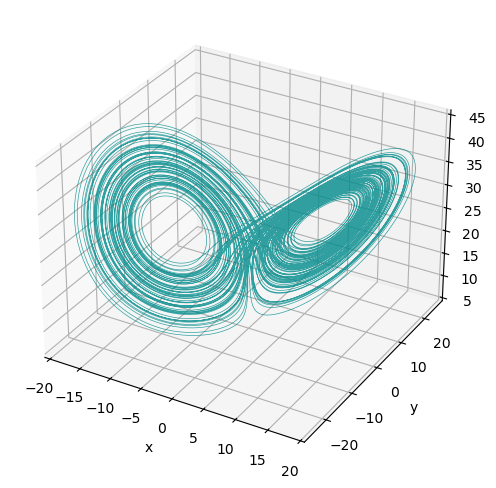

In [6]:
from mpl_toolkits.mplot3d import Axes3D

# Ploteamos las soluciones
# Número de puntos a graficar
N = 20000
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection="3d")
ax.plot3D(x[0:N], y[0:N], z[0:N], 'darkcyan', alpha=0.8, lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Cálculo de derivadas

Para realizar la regresión Lasso precisamos no sólo contar con la serie temporal de las variables, sino también con su derivada temporal. Para calcularla vamos a usar la función `gradient()` de numpy. Pueden encontrar el algoritmo numérico que utiliza para calcularlas [en su documentación](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html).

In [7]:
# Computamos las derivadas
# Noten que es preciso normalizar multiplicando por el paso temporal
x_deriv = np.gradient(x) * (1.0/dt)
y_deriv = np.gradient(y) * (1.0/dt)
z_deriv = np.gradient(z) * (1.0/dt)

# Lo unimos en una única matriz con el shape adecuado
mat_derivadas = np.asarray([x_deriv, y_deriv, z_deriv]).T
print(mat_derivadas.shape)

(800000, 3)


Vemos las variables y sus derivadas.

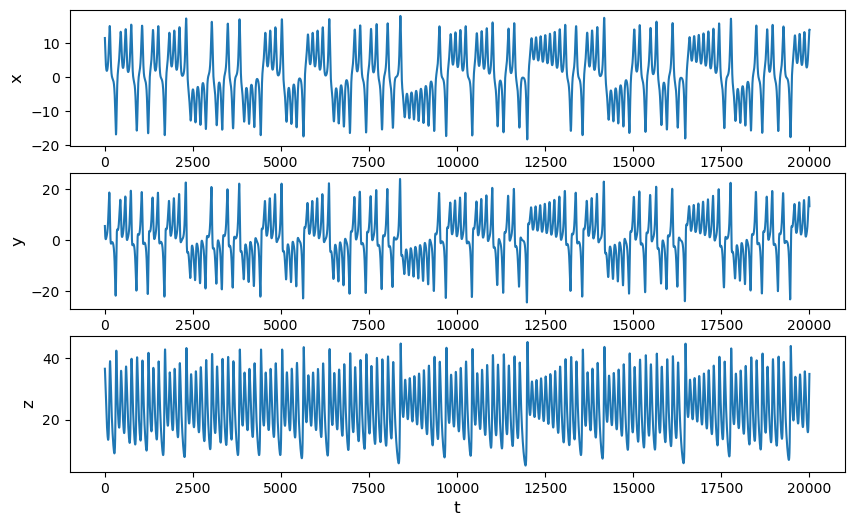

In [8]:
fig = plt.figure(figsize = (10, 6))
plt.subplot(3,1,1)
plt.plot(x[0:N])
plt.ylabel('x', fontsize=12)
plt.subplot(3,1,2)
plt.plot(y[0:N])
plt.ylabel('y', fontsize=12)
plt.subplot(3,1,3)
plt.plot(z[0:N])
plt.ylabel('z', fontsize=12)
plt.xlabel('t', fontsize=12)
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3801/2667628917.py:4: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$\dot{x}$', fontsize=12)
/tmp/ipykernel_3801/2667628917.py:7: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$\dot{y}$', fontsize=12)
/tmp/ipykernel_3801/2667628917.py:10: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('$\dot{z}$', fontsize=12)


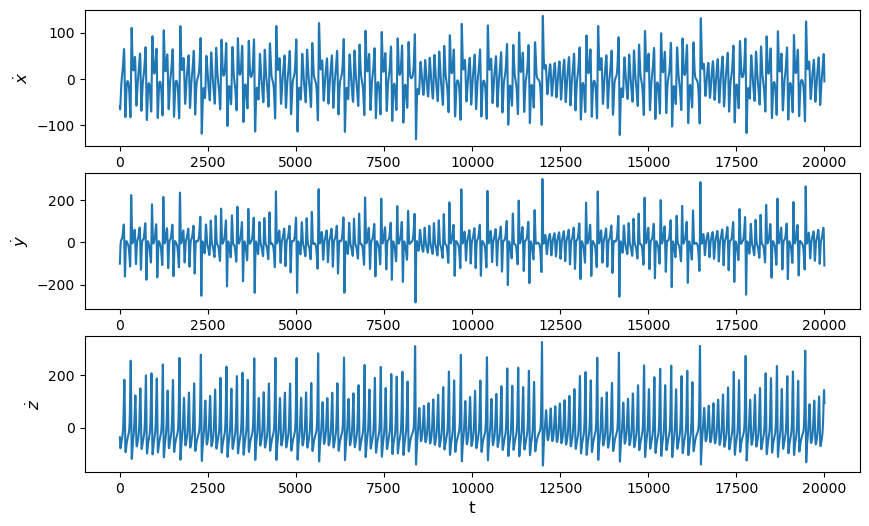

In [9]:
fig = plt.figure(figsize = (10, 6))
plt.subplot(3,1,1)
plt.plot(x_deriv[0:N])
plt.ylabel('$\dot{x}$', fontsize=12)
plt.subplot(3,1,2)
plt.plot(y_deriv[0:N])
plt.ylabel('$\dot{y}$', fontsize=12)
plt.subplot(3,1,3)
plt.plot(z_deriv[0:N])
plt.ylabel('$\dot{z}$', fontsize=12)
plt.xlabel('t', fontsize=12)
plt.show()

## Base de funciones

Además de las derivadas, también precisamos acomodar en la matriz `theta` los términos polinómicos que vamos a utilizar.

In [10]:
# Definimos la matriz vacía
theta = np.zeros((x.shape[0], 10))

# Completamos con los términos correspondientes
theta[:,0] = np.ones_like(x)
theta[:,1] = x
theta[:,2] = y
theta[:,3] = z
theta[:,4] = x*x
theta[:,5] = x*y
theta[:,6] = x*z
theta[:,7] = y*y
theta[:,8] = y*z
theta[:,9] = z*z

# Para luego comparar con los resultados obtenidos, definimos estas listas
terminos = ['1','x','y','z','xx','xy','xz','yy','yz','zz']
real_x_coef = [0,-10,10,0,0,0,0,0,0,0]
real_y_coef = [0,28,-1.0,0,0,0,-1.0,0,0,0]
real_z_coef = [0,0,0,-2.67,0,1.0,0,0,0,0]

**Observación:** Realizamos el cálculo de los atributos polinómicos de manera manual para transparentar el proceso. Pero existen soluciones de librerías, como `PolynomialFeatures` de `sklearn`, que lo realizan de manera automática (cosa que puede resultar muy cómoda, en especial para órdenes más altos).

## Reconstrucción de las ecuaciones con regresión Lasso

Sabemos que el sistema de ecuaciones que buscamos cuenta con una cantidad limitada de términos no nulos. Para evitar que se activen muchos términos en las ecuaciones, utilizamos la técnica de regularización de tipo **LASSO** o **$L_1$** para la regresión. Esto lo hacemos agregando un término de penalización a la función costo a minimizar, que sea la suma de los módulos de los valores de los coeficientes del modelo, multiplicados por un factor de penalización.

La librería Scikit-Learn cuenta varias implementaciones de este tipo de regresiones lineales con regularización. Primero vamos a utilizar la regresión Lasso clásica, [aquí su documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

In [11]:
from sklearn import linear_model

# Definimos el modelo
lasso = linear_model.Lasso(alpha=0.2, max_iter=10000, fit_intercept=False)

Noten que, al definir la matriz `theta`, agregamos una columna de unos como primera columna. De esta forma, el primer coeficiente de cada ecuación corresponde al término independiente de la misma. Es por esto que debemos setear `fit_intercept=False` al definir el modelo.

In [12]:
# Realizamos el ajuste
lasso.fit(theta, mat_derivadas)

Lasso(alpha=0.2, fit_intercept=False, max_iter=10000)

Inspeccionemos el valor numérico de los resultados:

In [13]:
print('Coeficientes en x:')
print(lasso.coef_[0,:])
print('\n')
print('Coeficientes en y:')
print(lasso.coef_[1,:])
print('\n')
print('Coeficientes en z:')
print(lasso.coef_[2,:])

Coeficientes en x:
[ 0.00000000e+00 -8.82347116e+00  9.25431855e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -3.27702103e-02 -0.00000000e+00
  2.07693659e-02  9.80926508e-06]


Coeficientes en y:
[-0.00000000e+00  2.62685834e+01 -6.13380610e-03 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -9.50562194e-01  0.00000000e+00
 -2.64163513e-02 -1.57560417e-05]


Coeficientes en z:
[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -2.58253135e+00
  3.35783526e-02  9.69089035e-01 -0.00000000e+00  5.54171471e-03
 -4.00568623e-07 -4.13548757e-03]


In [14]:
print('Coeficientes reales en x:')
print(real_x_coef)
print('\n')
print('Coeficientes reales en y:')
print(real_y_coef)
print('\n')
print('Coeficientes reales en z:')
print(real_z_coef)

Coeficientes reales en x:
[0, -10, 10, 0, 0, 0, 0, 0, 0, 0]


Coeficientes reales en y:
[0, 28, -1.0, 0, 0, 0, -1.0, 0, 0, 0]


Coeficientes reales en z:
[0, 0, 0, -2.67, 0, 1.0, 0, 0, 0, 0]


Para comparar los resultados obtenidos con los coeficientes originales, vamos a graficarlos.

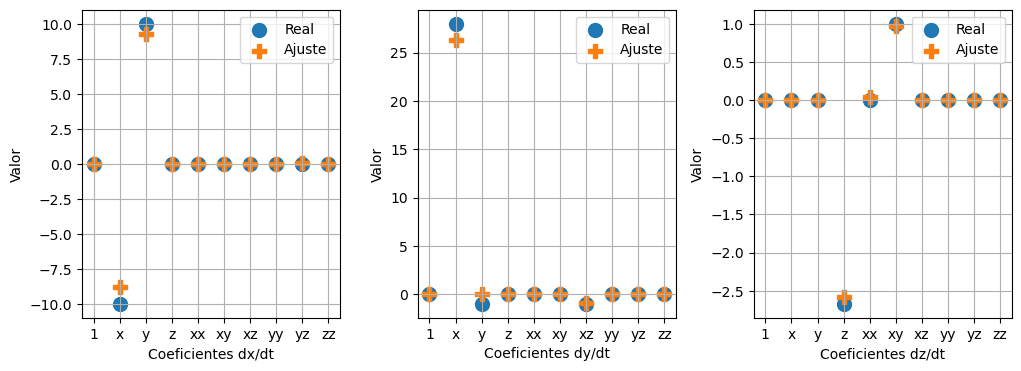

In [15]:
rango = np.arange(len(lasso.coef_[0,:]))
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.scatter(rango,real_x_coef, label='Real',s=100)
plt.scatter(rango,lasso.coef_[0,:], label='Ajuste',s=100,marker="P")
plt.xticks(rango, terminos)
plt.xlabel('Coeficientes dx/dt')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.scatter(rango,real_y_coef, label='Real',s=100)
plt.scatter(rango,lasso.coef_[1,:], label='Ajuste',s=100,marker="P")
plt.xticks(rango, terminos)
plt.xlabel('Coeficientes dy/dt')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.scatter(rango,real_z_coef, label='Real',s=100)
plt.scatter(rango,lasso.coef_[2,:], label='Ajuste',s=100,marker="P")
plt.xticks(rango, terminos)
plt.xlabel('Coeficientes dz/dt')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.subplots_adjust(wspace=0.3)
plt.show()

**Discutir:**

*   ¿Sobrevivieron únicamente los términos originales?
*   Observando el valor de los coeficientes en los términos que se corresponden con los de las ecuaciones originales, ¿Nota alguna particularidad?

Una pregunta interesante para hacerse es: **¿Cómo elegir el hiperparámetro alpha (factor de penalización)?**

No hay un valor óptimo universal para el hiperparámetro alpha, depende del dataset con el que estemos trabajando. Recuerden que normalmente no vamos a tener las ecuaciones reales para contrastar (de hecho estas ecuaciones son precisamente lo que estamos buscando).

Una forma válida de elegir el hiperparámetro es definir el número máximo de términos que pretendemos que aparezcan en nuestras ecuaciones. Pero, siendo que no conocemos la cantidad mínima de términos relevantes, esta decisión resulta arbitraria.

Otra forma es entrenar el modelo para distintos valores de alpha y evaluar la performance del modelo sobre un set distinto al de entrenamiento (test set). Esperamos que el modelo encontrado con el valor mas adecuado de alpha generalice mejor a los datos de test.

In [16]:
# Generamos un vector con los valores de alpha a explorar
alphas = np.logspace(-4, 1, 20)
print(alphas)

[1.00000000e-04 1.83298071e-04 3.35981829e-04 6.15848211e-04
 1.12883789e-03 2.06913808e-03 3.79269019e-03 6.95192796e-03
 1.27427499e-02 2.33572147e-02 4.28133240e-02 7.84759970e-02
 1.43844989e-01 2.63665090e-01 4.83293024e-01 8.85866790e-01
 1.62377674e+00 2.97635144e+00 5.45559478e+00 1.00000000e+01]


Separamos los datos en un set de entrenamiento y uno de prueba.

In [17]:
# Proporción entre train y test
proporcion = 0.8

# Índice de separación entre train y test
indice_test = int(proporcion * num_steps)

# Separamos la matriz Theta en 2 partes, una para el train set y otra para el test set.
theta_train = theta[:indice_test]
theta_test = theta[indice_test:]

# Hacemos lo mismo con las derivadas
x_deriv_train = x_deriv[:indice_test]
x_deriv_test = x_deriv[indice_test:]
y_deriv_train = y_deriv[:indice_test]
y_deriv_test = y_deriv[indice_test:]
z_deriv_train = z_deriv[:indice_test]
z_deriv_test = z_deriv[indice_test:]

**Atención:** Por una cuestión de simplicidad y velocidad, vamos a realizar el análisis solo para la ecuación correspondiente a la variable $x$. Pero el mismo análisis puede aplicarse a todo el sistema completo.

Para cada valor de alpha, entrenamos un modelo sobre el training set y lo evaluamos en el test set (en términos del `mean_squared_error` y del `mean_absolute_error`).

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Preparamos las listas donde vamos a guardar los datos
errores_absolute = []
errores_squared = []
coeficientes = []

# Recorremos los distintos valores de alpha
for value in alphas:
    print('Calculando con alpha = ', value)
    lasso = linear_model.Lasso(alpha=value, max_iter=10000, fit_intercept=False)
    lasso.fit(theta_train, x_deriv_train)
    x_deriv_test_predict = lasso.predict(theta_test)

    # Guardamos los coeficientes encontrados
    coeficientes.append(lasso.coef_)

    # Computamos el error cometido con 2 métricas distintas
    error_absolute = mean_absolute_error(x_deriv_test_predict, x_deriv_test)
    error_squared = mean_squared_error(x_deriv_test_predict, x_deriv_test)

    # Guardamos el error
    errores_absolute.append(error_absolute)
    errores_squared.append(error_squared)

Calculando con alpha =  0.0001
Calculando con alpha =  0.00018329807108324357
Calculando con alpha =  0.0003359818286283781
Calculando con alpha =  0.0006158482110660267
Calculando con alpha =  0.0011288378916846883
Calculando con alpha =  0.00206913808111479
Calculando con alpha =  0.00379269019073225
Calculando con alpha =  0.0069519279617756054
Calculando con alpha =  0.012742749857031334
Calculando con alpha =  0.023357214690901212
Calculando con alpha =  0.04281332398719392
Calculando con alpha =  0.07847599703514607
Calculando con alpha =  0.14384498882876628
Calculando con alpha =  0.26366508987303583
Calculando con alpha =  0.4832930238571752
Calculando con alpha =  0.8858667904100823
Calculando con alpha =  1.623776739188721
Calculando con alpha =  2.9763514416313193
Calculando con alpha =  5.455594781168514
Calculando con alpha =  10.0


Grafiquemos el error en función del parámetro alpha. Hacemos un zoom dentro del gráfico para ver los errores más de cerca.

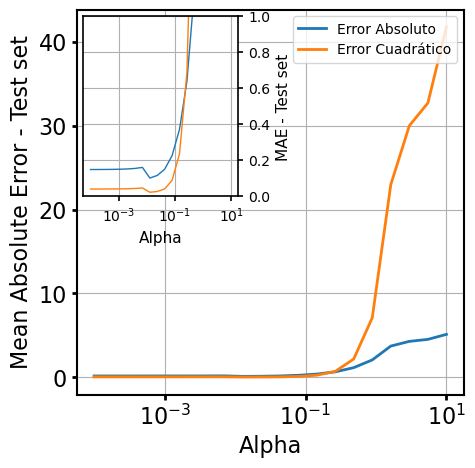

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1, 1, 1)
inset_axes = inset_axes(ax,
                    width="40%",
                    height=1.8,
                    loc=2)
ax.semilogx(alphas, errores_absolute, label='Error Absoluto', lw=2)
ax.semilogx(alphas, errores_squared, label='Error Cuadrático', lw=2)
ax.set_ylabel('Mean Absolute Error - Test set', fontsize=16)
ax.set_xlabel('Alpha', fontsize=16)
ax.grid(True)
ax.legend(loc='upper right')

inset_axes.semilogx(alphas, errores_absolute, label='Error Absoluto', lw=1)
inset_axes.semilogx(alphas, errores_squared, label='Error Cuadrático', lw=1)
inset_axes.set_ylim(0,1)
# inset_axes.set_xlim(5e-4,5e-1)
inset_axes.set_ylabel('MAE - Test set', fontsize=11)
inset_axes.set_xlabel('Alpha', fontsize=11)
inset_axes.grid(True)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
    inset_axes.spines[axis].set_linewidth(1.2)
ax.tick_params(width=2)
ax.tick_params(labelsize=16)

inset_axes.yaxis.set_ticks_position('right')
inset_axes.yaxis.set_label_position('right')
ax.tick_params(width=2)
ax.tick_params(labelsize=16)
inset_axes.tick_params(width=1.2)
inset_axes.tick_params(labelsize=10)

plt.show()

**Pregunta:** ¿Qué valor de alpha eligirían? Recuerden que, por lo general, un parámetro alpha más grande corresponde a un modelo más simple, con menos términos no nulos.

Por último vamos a graficar cómo varían los coeficientes a medida que variamos el valor de regularización.

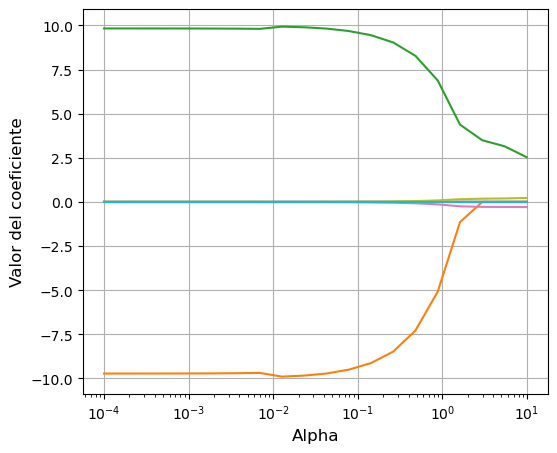

In [20]:
plt.figure(figsize=(6,5))
coef_mat = np.asarray(coeficientes).T
for i in range(coef_mat.shape[0]):
    ter = terminos[i]
    plt.semilogx(alphas,coef_mat[i],label=ter)
plt.ylabel('Valor del coeficiente', fontsize=12)
plt.xlabel('Alpha', fontsize=12)
plt.grid(True)
# plt.ylim(-0.05,0.05) # Luego descomenten esta linea para hacer zoom
plt.show()

### Ejercicio 1

Repita el proceso realizado, pero esta vez para la ecuación correspondiente a la variable $z$.

In [21]:
# # # COMPLETAR

**Observación:**

*  Una vez que encontaron cuáles son los términos que sobreviven en el valor de alpha óptimo, una buena estrategia podría ser volver a realizar una regresión, pero esta vez utilizando únicamente estos términos y reduciendo (o directamente anulando) el peso de la regularización (alpha). Este proceso normalmente mejora el valor de los coeficientes obtenidos.

## Reconstrucción de las ecuaciones con Sindy

Sindy es una librería de python dedicada a la identificación de sistemas dinámicos a partir de datos. La librería contiene varias utilizades dedicadas a este fin, entre ellas podemos destacar:
*   Distintos tipos de *sparse regressions*.
*   Funciones para computar atributos extras (variables transformadas).
*   Funciones para computar derivadas de señales.

La característica más importante de la librería es un tipo de regresión llamada **Sequentially thresholded least squares** ([Aqui su código](https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/stlsq.html)). Este algoritmo es muy parecido al proceso que realizamos en la sección anterior pero con la diferencia que usa una regularización tipo Ridge (la penalización que se agrega a la función costo tiene los coeficientes elevados al cuadrado) y que el algoritmo va *apagando* automáticamente los términos inferiores a cierto *threshold*.

In [22]:
# import math, builtins
# builtins.math = math

In [23]:
!pip3 install pysindy

ERROR: Could not find a version that satisfies the requirement pysindy (from versions: none)
ERROR: No matching distribution found for pysindy


Los submódulos de PySINDy están alineados con uno de los términos de la ecuación de aproximación antes mencionada

$$ \dot X \approx \Theta(X)\Xi. $$

* `pysindy.differentiate` realiza una diferenciación numérica para calcular $\dot X$ a partir de $X$;
* `pysindy.feature_library` permite al usuario especificar un conjunto de funciones de biblioteca y maneja la formación de $\Theta(X)$;
* `pysindy.optimizers` proporciona un conjunto de solucionadores de regresión LASSO para determinar $\Xi$.

El objeto `SINDy` encapsula un objeto de clase de cada uno de estos tres submódulos y los utiliza, junto con una matriz de datos proporcionada por el usuario, para encontrar un sistema dinámico gobernante.

La principal ventaja de utilizar esta librería es la simplicidad con la que se puede implementar la regresión. Noten que, a diferencia de lo que hicimos en la sección anterior, la librería calcula las derivadas y los términos polinómicos automáticamente.

In [24]:
import pysindy as ps

# Hiperparámetros
poly_order = 2
threshold = 0.05
alpha=0.1

# Definición del modelo
model = ps.SINDy(
    # Elegimos el optimizador a utilizar
    optimizer=ps.STLSQ(threshold=threshold,alpha=alpha),
    # Elegimos los features (términos de las ecuaciones) a utilizar
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    # Le ponemos un nombre a las variables
    feature_names = ['x', 'y', 'z']
)

# Adecuamos nuestros datos en la matriz 'data'
data = np.asarray([x,y,z]).T

# En la primer dimensión van los pasos temporales y en la segunda las varables
print(data.shape)


ModuleNotFoundError: No module named 'pysindy'

Finalmente entrenamos el modelo:

In [ ]:
# Entrenamiento
model.fit(data, t=dt)
model.print()

Noten que los términos que sobrevivieron en las ecuaciones son los correctos y, además, los valores numéricos de los coeficientes encontrados son increíblemente cercanos a los del sistema original!

Por último, podemos usar la misma librería para integrar el modelo encontrado y comparar las soluciones con las del sistema original.

In [ ]:
# Definimos el vector de tiempos
tiempos = np.arange(0, 100, dt)
# Integramos el sistema encontrado durante ese tiempo
data_sim = model.simulate(data[0], tiempos)

In [ ]:
# Graficamos las soluciones
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection="3d")
ax.plot3D(data_sim[:,0], data_sim[:,1], data_sim[:,2], alpha=0.85)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Lorenz de las ecuaciones encontradas')
plt.show()

# Ejercicio 2

Busquen reconstruir las ecuaciones de las oscilaciones amortiguadas del péndulo con las variables que extrajimos en el colab de "ajustes de datos". Comparen con el sistema conocido

$$
    \frac{dx_1}{dt} = x_2 \\
    \frac{dx_2}{dt} = -kx_1 - bx_2
$$

In [ ]:
# # # COMPLETAR

# Reconstrucción del oscilador de relajación de Van Der Pol

Siendo que funcionaron tan bien en un atractor caótico, a esta altura resulta muy tentador pensar que esta clase de métodos funcionarán bien en cualquier tipo de sistemas.

Probemos con datos simulados a partir del sistema:


In [ ]:
def van_der_pol(t, X, mu=7.0):
    x, y = X
    x_dot = y
    y_dot = mu * (1 - x * x) * y - x
    return [x_dot, y_dot]

In [ ]:
dt = 0.4
t_max = 500
t_eval = np.arange(0, t_max, dt)
t_span = [t_eval[0], t_eval[-1]]
X0 = [-2, 0]
solucion_vanderpol = sp.integrate.solve_ivp(van_der_pol, t_span, X0, t_eval=t_eval, args=(7,))
x, y = solucion_vanderpol.y

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x, y, 'o')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Diagrama de Fases', fontsize=12)
plt.subplot(1,2,2)
plt.plot(t_eval[:100], x[:100], '-o')
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('x', fontsize=12)
plt.title('Evolucion de x(t)', fontsize=12)
plt.show()

Este es un oscilador de relajación muy popular llamado oscilador de **Van Der Pol**, cuyas ecuaciones son:

$$
	\begin{bmatrix} \frac{dx}{dt} \\ \frac{dy}{dt} \end{bmatrix}
	= \begin{bmatrix} y \\ -x + \mu y - \mu x^2y  \end{bmatrix}
$$


La dinámica en este caso no es muy compleja: un único término cúbico y 3 términos lineales dan lugar a una solución de tipo ciclo limite.

Además, contamos con más de 20 samples por cada oscilación y ni siquiera estamos agregando ruido. Si pensamos en un escenario experimental, este sería un caso prácticamente ideal.



**Vamos a hacer el siguiente análisis:**

*   Probemos de usar el método para reconstruir las ODEs y exploremos los resultados obtenidos para este simple sistema dinámico.

*   ¿Coinciden los términos encontrados con los del sistema original? ¿Son cualitativamente similares las soluciones?

*   ¿Cuál les parece que puede ser la causa de este desempeño?

*   Cambiemos el valor del parámetro $\mu$ en la función `val_der_pol()` de $\mu = 7$ a $\mu = 1$ y volvamos a realizar el ejercicio. ¿Mejora o empeora la capacidad de reproducir las ecuaciones del sistema? ¿Qué cambió?

In [ ]:
import pysindy as ps

# Hiperparámetros
poly_order = 3
threshold = 0.05
alpha=0.1

# Definición del modelo
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold,alpha=alpha),
    feature_library=ps.PolynomialLibrary(degree=poly_order,include_bias=True),
    feature_names = ['x', 'y']
)

data = np.asarray([x,y]).T

# En la primera dimensión van los pasos temporales y en la segunda las varables
print(data.shape)


In [ ]:
# Entrenamiento
model.fit(data, t=dt)
model.print()

Si graficamos las soluciones del sistema encontrado contra las del sistema original:

In [ ]:
tiempos = np.arange(0, 100, dt)
data_sim = model.simulate(data[0], tiempos)

In [ ]:
x_sim = data_sim[:,0]
y_sim = data_sim[:,1]

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x, y, 'o')
plt.plot(x_sim, y_sim, 'o')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Diagrama de Fases', fontsize=12)
plt.xlim(-2.5,2.5)
plt.subplot(1,2,2)
plt.plot(t_eval[:100], x[:100], '-o')
plt.plot(t_eval[:100], x_sim[:100], '-o')
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('x', fontsize=12)
plt.title('Evolucion de x(t)', fontsize=12)
plt.show()

Con $\mu = 1$

In [ ]:
dt = 0.4
t_max = 500
t_eval = np.arange(0, t_max, dt)
t_span = [t_eval[0], t_eval[-1]]
X0 = [-2, 0]
solucion_vanderpol = sp.integrate.solve_ivp(van_der_pol, t_span, X0, t_eval=t_eval, args=(1,))
x, y = solucion_vanderpol.y


In [ ]:
import pysindy as ps

# Hiperparámetros
poly_order = 3
threshold = 0.05
alpha=0.1

# Definición del modelo
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold,alpha=alpha),
    feature_library=ps.PolynomialLibrary(degree=poly_order,include_bias=True),
    feature_names = ['x', 'y']
)

data = np.asarray([x,y]).T
# En la primera dimensión van los pasos temporales y en la segunda las varables
print(data.shape)


In [ ]:
# Entrenamiento
model.fit(data, t=dt)
model.print()

In [ ]:
tiempos = np.arange(0, 100, dt)
data_sim = model.simulate(data[0], tiempos)
x_sim = data_sim[:,0]
y_sim = data_sim[:,1]

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x, y, 'o')
plt.plot(x_sim, y_sim, 'o')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Diagrama de Fases', fontsize=12)
plt.xlim(-2.5,2.5)
plt.subplot(1,2,2)
plt.plot(t_eval[:100], x[:100], '-o')
plt.plot(t_eval[:100], x_sim[:100], '-o')
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('x', fontsize=12)
plt.title('Evolucion de x(t)', fontsize=12)
plt.show()

## Consideraciones de la derivada numérica

Como vimos, el método permite reconstruir las ecuaciones haciendo una regresión entre las derivadas y las variables transformadas. Esto es posible aún cuando no tengamos las derivadas como dato, haciendo derivación numérica. No obstante, como vimos en la 2da clase, la derivada numérica puede ser muy sensible o ruidosa o en todo caso requiere de especial cuidado. Los métodos habituales de diferencias finitas tienden a amplificar mucho el ruido presente en los datos. Tal es así, que SINDy usa un método de derivación regularizada llamado *Total Variation Regularized Numerical Differentiation (TVRegDiff)*, que le permite obtener derivadas numéricas más suaves. Pueden encontrar una descripción del problema y el método en https://oliver-k-ernst.medium.com/how-to-differentiate-noisy-signals-2baf71b8bb65, o en la publicación original https://onlinelibrary.wiley.com/doi/10.5402/2011/164564.

Aún usando esta forma regularizada de cálculo numérico de la derivada, sigue siendo un tema que se debe abordar con criterio cuando se reconstruyen ODEs. De hecho, el problema que estamos encontrando para el oscilador de relajación con $\mu=7$ justamente se debe a que la derivada tiene cambios muy bruscos, como habrán notado.

Veamos cómo son las soluciones y sus derivadas numéricas (usando np.gradient) para $\mu=1$ y $\mu=7$.

In [ ]:
solucion_vanderpol_mu7 = sp.integrate.solve_ivp(van_der_pol, t_span, X0, t_eval=t_eval, args=(7,))
x_mu7, y_mu7 = solucion_vanderpol_mu7.y
solucion_vanderpol_mu1 = sp.integrate.solve_ivp(van_der_pol, t_span, X0, t_eval=t_eval, args=(1,))
x_mu1, y_mu1 = solucion_vanderpol_mu1.y

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t_eval[:100], x_mu1[:100], '-o', label='mu = 1')
plt.plot(t_eval[:100], x_mu7[:100], '-o', label='mu = 7')
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('x', fontsize=12)
plt.title('Evolucion de x(t)', fontsize=12)
plt.legend()
plt.subplot(1,2,2)
plt.plot(t_eval[:100], np.gradient(x_mu1)[:100], '-o', label='mu = 1')
plt.plot(t_eval[:100], np.gradient(x_mu7)[:100], '-o', label='mu = 7')
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('$\dot{x}$', fontsize=12)
plt.title('Derivada de x(t)', fontsize=12)
plt.legend()
plt.subplots_adjust(wspace=0.3)
plt.show()

En particular, SINDy usa el paquete `derivative` (https://derivative.readthedocs.io/en/latest/) para calcular la derivada con TVRegDiff, y el hiperparámetro `alpha` es el que define la regularización en el cálculo de la derivada. Un valor muy chico dará una solución muy fiel a la señal original, pero que puede ser muy ruidosa. En cambio, un valor muy grande dará una derivada que será menos fiel a la señal original. Se debe entonces encontrar un valor óptimo de acuerdo al balance que se quiera lograr entre supresión de oscilaciones y fidelidad a los datos, que dependerá del problema particular. No obstante, no siempre se puede encontrar una situación ideal cuando el problema está mal condicionado, por ejemplo por estar fuertemente subsampleado.

### Ejercicio 3

Para probar el efecto del alpha, pruebe de simular datos de la función $f(t) = |t - 1/2|$, evaluando en 100 valores de $t$ equidistantes dentro del intervalo [0, 1], y agregando ruido gaussiano de desvío estándar 0.05. Compute las derivadas para distintos valores de alpha, usando el método que usa SINDy (debería ser `ps.differentiation.sindy_derivative.dxdt(f, t, kind='trend_filtered', order=0, alpha=alpha)`). Qué observa?

In [ ]:
# # # COMPLETAR

### Ejercicio 4

Pruebe de modificar los parámetros alpha y thresholds para ver si puede mejorar la reconstrucción de las ODEs en el oscilador de relajación.

In [ ]:
# # # COMPLETAR